# About

This script generates the theoretical plots for the analysis in the 2-dim Kuramoto system with adaptive delays.
To find the synchronization frequency and phase difference, we have the following equation for $\Omega$:
$$\mathcal{R}_\kappa(\Omega) := \Omega -\omega_0 - g \sin \left(-\Omega \left(\tau^0 + \kappa\left( \frac{\omega_0 - \Omega}{g} \right) \right) + \arcsin \left( \frac{\omega_0 - \Omega}{g} \right) \right)$$
and the corresponding positive phase difference $\Delta = \phi_2 - \phi_1$ and delays at equilibrium is given by

$$ \Delta = \arcsin \left( \frac{\omega_0 - \Omega}{g} \right) > 0 $$
$$ \tau^E = \tau^0 + \kappa \sin(\Delta_{12})$$

The set of eigenvalues $\lambda \in \mathbb{C}$ pertaining to the synchronized state is given by the transcendental equation $P(\lambda) + Q(\lambda)e^{-\lambda\tau^E} = 0$, where the polynomials $P(\lambda), Q(\lambda)$ are
\begin{align*}
P(\lambda) &= \lambda^3 + (1 + C_{12} + C_{21}) \lambda^2 + (\tilde{\kappa}C_{12} + (1 + C_{12})C_{21})\lambda + C_{12}C_{21} \\
Q(\lambda) &= -C_{12}C_{21}(\lambda+1)
\end{align*}

where $\tilde{\kappa} = 1 - \Omega\kappa C_0$, $C_0 = \cos(\Delta)$, $C_{12} = g\cos(-\Omega\tau^E + \Delta)$, $C_{21} = g\cos(\Delta)$. MATLAB is used to solve the eigenvalue distributions given by the equation above, and provides the parameters used. The error mesh is imported here in order to create the plots. The MATLAB script is found in 'sec4_2D_analysis.mat'

# Library

In [1]:
from __future__ import division, print_function

%matplotlib inline
# Toggle on/off
# %matplotlib notebook

import os
import numpy as np
import scipy.io as sio
from scipy import optimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.transforms as tsfm
import math
from math import pi

from lib import *

from IPython.display import clear_output

# Directories

In [2]:
# Data files from Matlab
import_folder = 'sec4_2D_analysis'

# Directory
dir_main = os.getcwd()
dir_im = os.path.join(dir_main, 'matlab', 'data', import_folder)

dir_sync = os.path.join(dir_im, 'sync_freqs.mat')

# Import and process files

In [3]:
# SYNC STATES
dict_sync = sio.loadmat(dir_sync)

# Import parameters
g = dict_sync['g'][0,0]
w0 = dict_sync['omega0'][0,0]
tau0 = dict_sync['tau0'][0,0]
gain = dict_sync['gain'][0,0]

parameters = {'g': g, 'omega0': w0, 'tau0': tau0, 'gain': gain}

# Import arrays
Omega_arr0 = dict_sync['Omega_arr']
err_arr = dict_sync['error_arr']

# Sync states and phase differences
Omegas = dict_sync['Omegas']
Deltas = dict_sync['Deltas']
Omega_errs = dict_sync['error']

# Synchronous states

Plot synchronous states with increasing gain.

In [4]:
# Fixed-point functions
Omega_fun0 = lambda Omega: Omega - w0 + g*np.sin(Omega*tau0)
Omega_fun1 = funlib.Omega2D({'g': g, 'omega0': w0, 'tau0': tau0, 'gain': gain/2})
Omega_fun2 = funlib.Omega2D({'g': g, 'omega0': w0, 'tau0': tau0, 'gain': gain})

# Generate arrays with increasing gain
Omega_arr = np.linspace(w0 - g, w0 + g, num=1000)
err_arr0 = Omega_fun0(Omega_arr)
err_arr1 = Omega_fun1(Omega_arr)
err_arr2 = Omega_fun2(Omega_arr)

## Acquire eigenvalue data

In [5]:
# Filenames
filenames = os.listdir(dir_im)
filenames.remove('sync_freqs.mat')

# Arrays to be plotted
syncOmegas = np.zeros(len(filenames))
largestreeigs = np.zeros(len(filenames))

# List of eigenvalue arrays
dist_eigs = []

# Error log tolerance
posTol = 0.01
neglogTol = -1.0
withinzero = 0.0001

for k in range(len(filenames)):
    dir_eig = os.path.join(dir_im, filenames[k])
    dict_eig = sio.loadmat(dir_eig)
    
    # Get Omega
    syncOmegas[k] = dict_eig['Omega'][0,0]
    
    # Get largest eigenvalue
    eigs_found = dict_eig['eigs']
    eigs_error = dict_eig['eigerrors']
    
    # Keep only eigenvalue < tol
    # print(eigs_found)
    # eigs_found = eigs_found[eigs_error < tol]
    
    # Check the error of each eigenvalue found using det function
    Omega = dict_eig['Omega'][0,0]
    Delta = dict_eig['Delta'][0,0]
    
    detFun = funlib.eig2D_det(Omega, Delta, parameters)
    
    for i in range(eigs_found.size):
        z = eigs_found[i]
        if z.real > 0:
            err = np.abs(detFun(z))
            if err > posTol:
                eigs_found[i] = np.NaN
                      
        elif z.real < 0:
            err = np.log10(np.abs(detFun(z)))
            if err > neglogTol:
                eigs_found[i] = np.NaN
                
    # Get eigenvalue roots
    dist_eigs.append(eigs_found)
    
    # Largest non-zero eigenvalue
    # print(eigs_found.real[np.abs(eigs_found) > withinzero])
    largestreeigs[k] = np.max(eigs_found.real[np.abs(eigs_found) > withinzero])

# Sort in increasing Omega order
inds_sort = np.argsort(syncOmegas)

syncOmegas = syncOmegas[inds_sort]
largestreeigs = largestreeigs[inds_sort]
dist_eigs = [dist_eigs[inds_sort[i]] for i in range(inds_sort.size)]

C:\Users\Daniel\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater


## Find any real eigenvalues

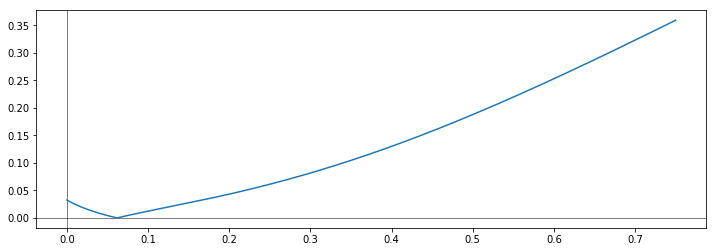

In [6]:
# Which sync state:
ind = 0

OmegaTest = syncOmegas[ind]
DeltaTest = np.arcsin((w0 - OmegaTest)/g)

detFun = funlib.eig2D_det(OmegaTest, DeltaTest, parameters)

z_arr = np.linspace(0, 0.75, num=1000)
z_imag = 0.175
err_arr = np.log10(1 + np.abs(detFun(z_arr+1j*z_imag)))

figure, ax = plt.subplots(1, figsize = (12, 4))
ax.plot(z_arr, err_arr)
ax.axhline(y=0, color='black', linewidth=0.5, zorder=0)
ax.axvline(x=0, color='black', linewidth=0.5, zorder=0)

## Eigenvalue plot function

In [7]:
def plot_eigs(ax, dict_eig, parameters, marker1={}, marker2={}, posTol=1, negTol=0):
    '''
    Plot function for eigenvalues, using the imported MATLAB dictionary.
    '''
    
    # Meshes
    u_mesh = dict_eig['re']
    v_mesh = dict_eig['im']
    err_mesh = dict_eig['logerror']
    
    # Located eigenvalues
    eig_found = dict_eig['eigs']
    eig_error = dict_eig['eigerrors']
    
    # Only plot eigenvalues within tolerance
    eigs_found = eig_found[np.abs(eig_error) < tol]
    
    # Check the error of each eigenvalue found using det function
    Omega = dict_eig['Omega'][0,0]
    Delta = dict_eig['Delta'][0,0]
    
    detFun = funlib.eig2D_det(Omega, Delta, parameters)
    
    for i in range(eigs_found.size):
        z = eigs_found[i]
        if z.real > 0:
            err = np.abs(z - detFun(z))
            if err < posTol:
                print(f'Eig = {z}, error = {err}')
            else:
                eigs_found[i] = np.NaN
                      
        elif z.real < 0:
            err = np.log10(np.abs(z - detFun(z)))
            if err < negTol:
                print(f'Eig = {z}, error = {err}')
            else:
                eigs_found[i] = np.NaN
                      
    # ax.pcolormesh(u_mesh, v_mesh, err_mesh, cmap='binary', alpha=0.5, vmin=0, vmax=1)
    ax.scatter(eig_found.real, eig_found.imag, **marker1, zorder=2)
    ax.scatter(polyroots.real, polyroots.imag, **marker2, zorder=1)

# Plots

In [8]:
# Choose which eigenvalues to plot (on index)
ind1 = 2
ind2 = 3

## Configure options

In [9]:
# Plot positions [left, bottom, width, height] 
bbox0 = [0.15, 0.55, 0.25, 0.3]  # Fig 2a: Synchronization states (roots of R_gain)
bbox1 = [0.15, 0.1, 0.25, 0.3]  # Fig 2b: Non-zero cubic roots (real part)
bbox2 = [0.5, 0.1, 0.2, 0.8] # Fig 2c: Eigenvalue plot of 1st Omega
bbox3 = [0.8, 0.1, 0.2, 0.8] # Fig 2d: Eigenvalue plot of 2nd Omega
# bbox4 = [0.95, 0.1, 0.04, 0.8] # Colour legend for fig 2c, fig 2d heatmaps

# Sign log
slog = lambda x: np.sign(x)*np.log10(1 + np.abs(x))

# Colours
color_errA0 = 'magenta'
color_errA1 = 'orange'
color_errA2 = 'blue'

# Linewidths
axwidthA1 = axwidthB1 = 0.75
axwidthA2 = axwidthB2 = 1.5

# Alphas
alphaA = 0.8
alphaB = 0.9

# Markers
markerB = {'s': 40, 'marker': 'd', 'color': 'blue'}
markerC = {'s': 25, 'marker': 'o', 'color': 'black'}
markerD = {'s': 150, 'marker': '*', 'color': 'blue'}

## Generate figure

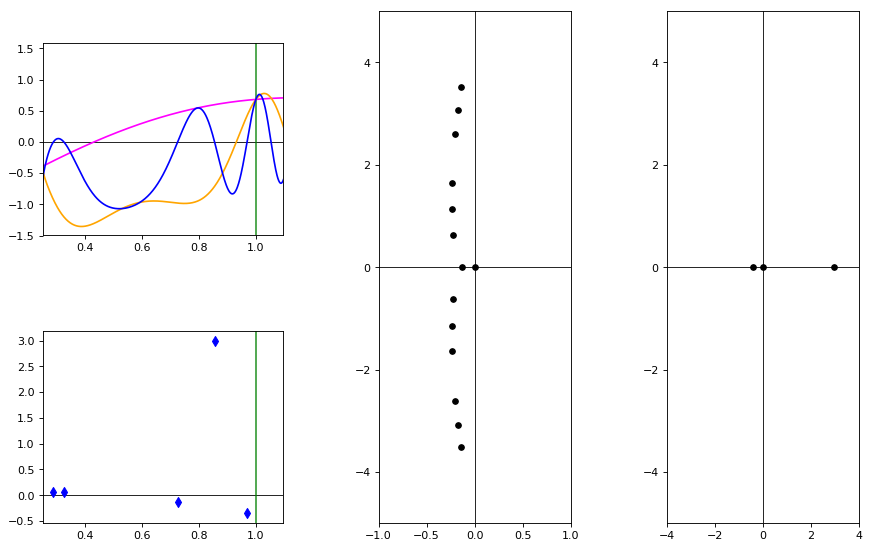

In [10]:
fig, ax = plt.subplots(4, figsize=(12, 8), dpi=80)

# Set positions
ax[0].set_position(bbox0)
ax[1].set_position(bbox1)
ax[2].set_position(bbox2)
ax[3].set_position(bbox3)
# ax[4].set_position(bbox4)

# PLOT ARRAYS

# Plot sync states
ax[0].plot(Omega_arr, err_arr0, color=color_errA0, zorder=2)
ax[0].plot(Omega_arr, err_arr1, color=color_errA1, zorder=2)
ax[0].plot(Omega_arr, err_arr2, color=color_errA2, zorder=2)

# ax[0].scatter(syncOmegas, np.zeros(syncOmegas.size), **markerB, zorder=2)

# Plot maximal roots
ax[1].scatter(syncOmegas, largestreeigs, **markerB, zorder=2)
ax[1].set_xlim(left=w0-g, right=w0+g/8)

# Plot eigenvalues
ax[2].scatter(dist_eigs[ind1].real, dist_eigs[ind1].imag, **markerC, zorder=2)
ax[3].scatter(dist_eigs[ind2].real, dist_eigs[ind2].imag, **markerC, zorder=2)

# ADJUST

# Sync plot
ax[0].set_xlim(left=w0-g, right=w0+g/8)
ax[0].axhline(y=0, color='black', linewidth=axwidthA1, zorder=0)
ax[0].axvline(x=w0, color='green', linewidth=axwidthA2, alpha=alphaA, zorder=0)

# Cubic plot
# ax[1].set_xlim(left=w0-g, right=w0+g/4)
ax[1].axhline(y=0, color='black', linewidth=axwidthB1, zorder=0)
ax[1].axvline(x=w0, color='green', linewidth=axwidthB2, alpha=alphaA, zorder=0)

# Eigenvalue plot
ax[2].set_xlim(left=-1, right=1)
ax[2].set_ylim(bottom=-5, top=5)
ax[2].axhline(y=0, color='black', linewidth=axwidthA1, zorder=0)
ax[2].axvline(x=0, color='black', linewidth=axwidthA1, zorder=0)

ax[3].set_xlim(left=-4, right=4)
ax[3].set_ylim(bottom=-5, top=5)
ax[3].axhline(y=0, color='black', linewidth=axwidthA1, zorder=0)
ax[3].axvline(x=0, color='black', linewidth=axwidthA1, zorder=0)

# Statistics

In [11]:
largest_eig1 = largestreeigs[ind1]
largest_eig2 = largestreeigs[ind2]
print(f'Frequencies: \n 1st sync freq = {syncOmegas[ind1]} \n 2nd sync freq = {syncOmegas[ind2]}')
print(f'Largest real eig for 1st sync freq = {largest_eig1}')
print(f'Largest real eig for 2st sync freq = {largest_eig2}')
print(syncOmegas)

Frequencies: 
 1st sync freq = 0.725 
 2nd sync freq = 0.8549
Largest real eig for 1st sync freq = -0.126
Largest real eig for 2st sync freq = 2.989
[0.2883 0.325  0.725  0.8549 0.9689]
